# CIFAR Training in PyTorch

:label:`sec_customstorch`


In this tutorial, we are showing an example of doing HPO using AutoGluon using PyTorch.
AutoGluon is a framework agnostic HPO toolkit, which is compatible with
any training code written in python. (Training code is adapted from
[git repo](https://github.com/kuangliu/pytorch-cifar)).

Import the torch and torchvision:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

## Start with A CIFAR10 Example

### Data Transforms

Standard data transforms during training and validation:

In [2]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

# the datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### Main Training Loop

The following `train_cifar` function is a normal training code a user would write for
training on CIFAR dataset. Python users typically use an argparser for conveniently
changing default values. The only extra component introduced is `reporter`,
which we will discribe later.

In [3]:
def train_cifar(args, reporter):
    # get varibles from args
    lr = args.lr
    wd = args.wd
    epochs = args.epochs
    net = args.net
    print('lr: {}, wd: {}'.format(lr, wd))

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Model
    net = net.to(device)

    if device == 'cuda':
        net = nn.DataParallel(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=wd)

    # datasets and dataloaders
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    # Training
    def train(epoch):
        net.train()
        train_loss, correct, total = 0, 0, 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    def test(epoch):
        net.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        acc = 100.*correct/total
        reporter(epoch=epoch, accuracy=acc)

    for epoch in tqdm(range(0, epochs)):
        train(epoch)
        test(epoch)

## AutoGluon HPO

In this sectin, we are talking about

### Define A Searchable Network Achitecture

Let's define a 'dynamic' network with searchable 
configurations by simply adding a decorator :func:`autogluon.obj`.
In this example, we only search two arguments `hidden_conv` and
`hidden_fc`, which represent the hidden channels in convolutional
layer and fully connected layer. More info about searchable space
is available at :meth:`autogluon.space`.

In [4]:
import autogluon as ag

@ag.obj(
    hidden_conv=ag.space.Int(6, 12),
    hidden_fc=ag.space.Categorical(80, 120, 160),
)
class Net(nn.Module):
    def __init__(self, hidden_conv, hidden_fc):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_conv, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(hidden_conv, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, hidden_fc)
        self.fc2 = nn.Linear(hidden_fc, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Convert the Training Function to Be Searchable

We can simply add a decorator :func:`autogluon.args` to convert the `train_cifar`
function to AutoGluon Searchable.

In [5]:
@ag.args(
    lr = ag.space.Real(0.01, 0.2, log=True),
    wd = ag.space.Real(1e-4, 5e-4, log=True),
    net = Net(),
    epochs=5,
)
def ag_train_cifar(args, reporter):
    return train_cifar(args, reporter)

### Create the Scheduler and Launch the Experiment

In [6]:
myscheduler = ag.scheduler.FIFOScheduler(ag_train_cifar,
                                         resource={'num_cpus': 4, 'num_gpus': 1},
                                         num_trials=2,
                                         time_attr='epoch',
                                         reward_attr="accuracy")
print(myscheduler)

FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.16.19.215/4654/1' processes=1 threads=8, memory=64.38 GB>, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
})



In [7]:
myscheduler.run()
myscheduler.join_jobs()

lr: 0.1383745909353965, wd: 0.00018963956721637821




lr: 0.019479302878962705, wd: 0.00010333278586959975


Plot the results.

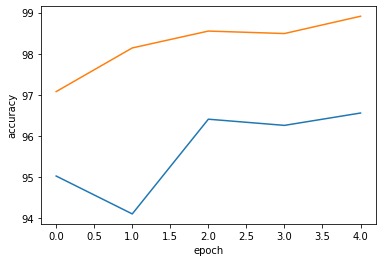

The Best Configuration and Accuracy are: {'lr': 0.019479302878962705, 'net.hidden_conv': 10, 'net.hidden_fc.choice': 0, 'wd': 0.00010333278586959975}, 98.91


In [8]:
myscheduler.get_training_curves(plot=True,use_legend=False)
print('The Best Configuration and Accuracy are: {}, {}'.format(myscheduler.get_best_config(),
                                                               myscheduler.get_best_reward()))

Finish and exit:

In [9]:
ag.done()